In [10]:
import pyorc
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from dask.diagnostics import ProgressBar
from matplotlib import patches

In [11]:
cam_config = pyorc.load_camera_config(R"./artifact/configCam.json")
video_file = R"..\..\res\pont-cour.mp4"

In [12]:
stabilize = [
    [1500, 900],   # plus à droite et en bas
    [1300, 600],   # plus à droite et en haut
    [400, 600],    # plus à gauche et en haut
    [250, 900]     # plus à gauche et en bas
]
video = pyorc.Video(
    video_file,
    camera_config=cam_config,
    start_frame=0,
    end_frame=125,
    stabilize=stabilize,
    h_a=0.,
)

Scanning video: 100%|██████████| 107/107 [00:01<00:00, 100.37it/s]
Deriving stabilization parameters from second frame onwards: 100%|██████████| 106/106 [00:01<00:00, 69.18it/s]


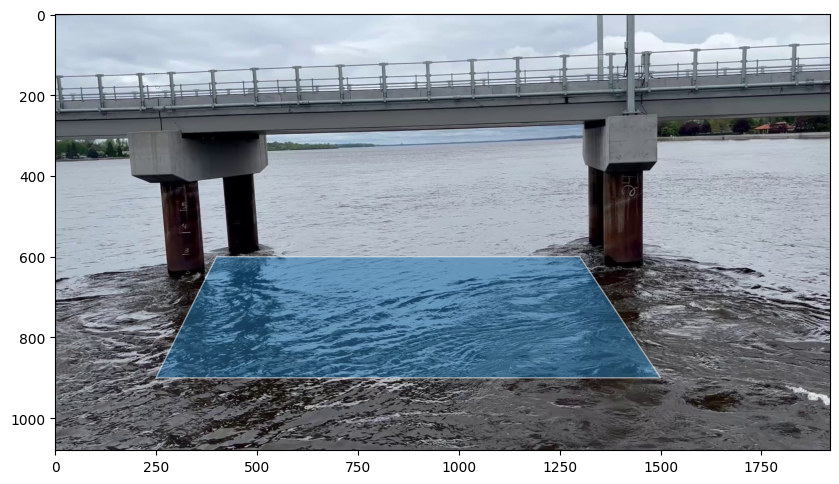

In [13]:
patch_kwargs = {
    "alpha": 0.5,
    "zorder": 2,
    "edgecolor": "w",
    "label": "Area of interest",
}
f, ax = plt.subplots(1, 1, figsize=(10, 6))

frame = video.get_frame(0, method="rgb")
# plot frame on a notebook-style window
ax.imshow(frame)
# add the polygon to the axes
patch = patches.Polygon(
    stabilize,
    **patch_kwargs
)
p = ax.add_patch(patch)

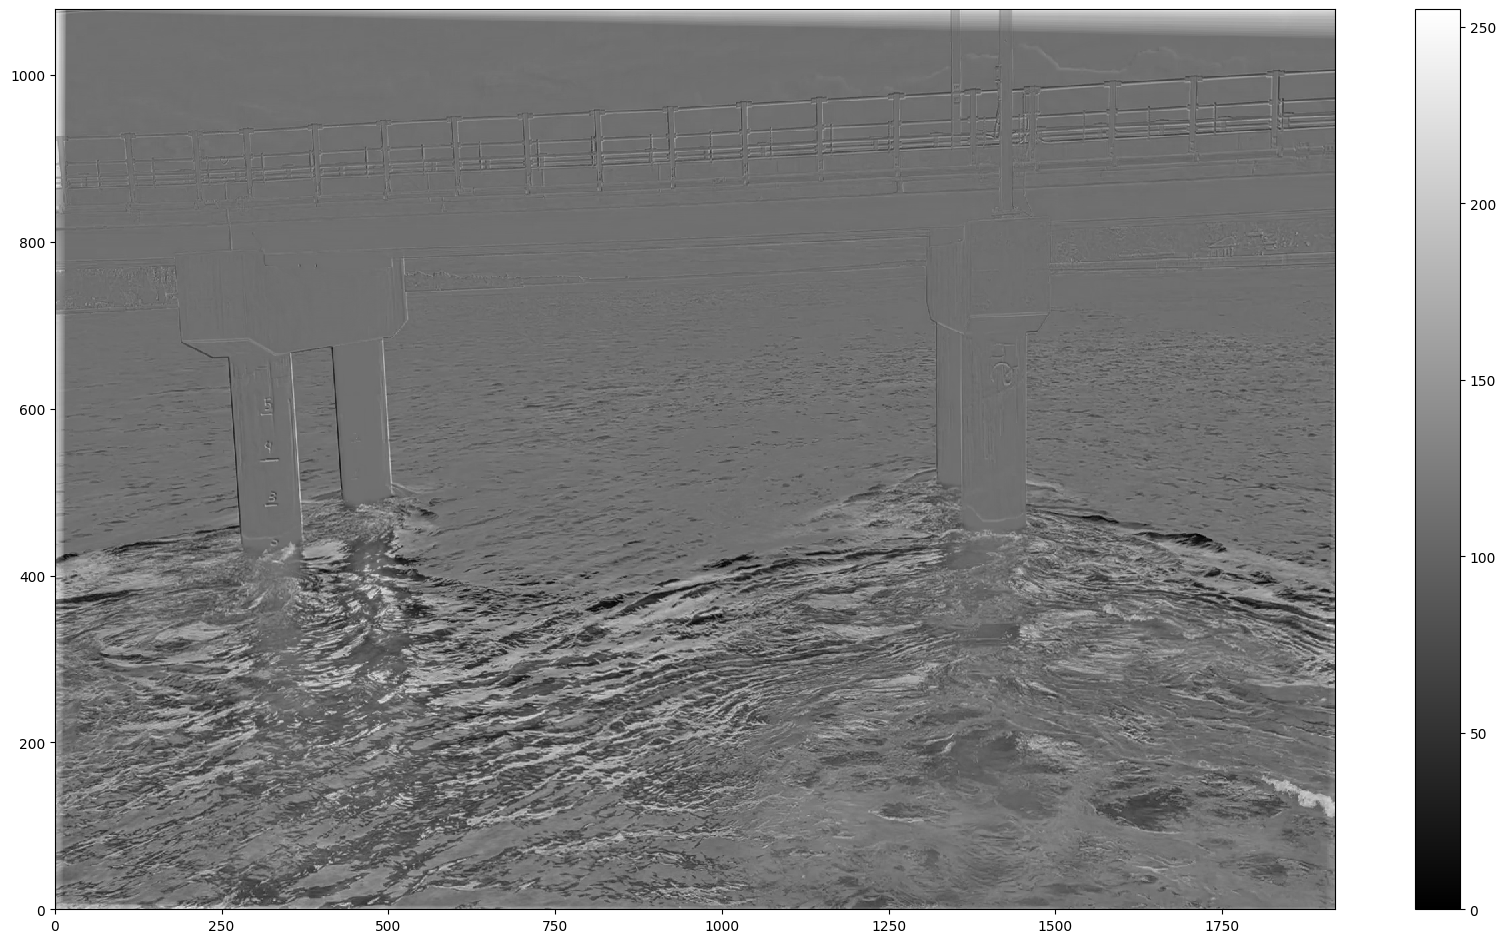

In [14]:
da = video.get_frames()
da_norm = da.frames.normalize()
p = da_norm[0].frames.plot(cmap="gray")
plt.colorbar(p)

<Figure size 1600x900 with 0 Axes>

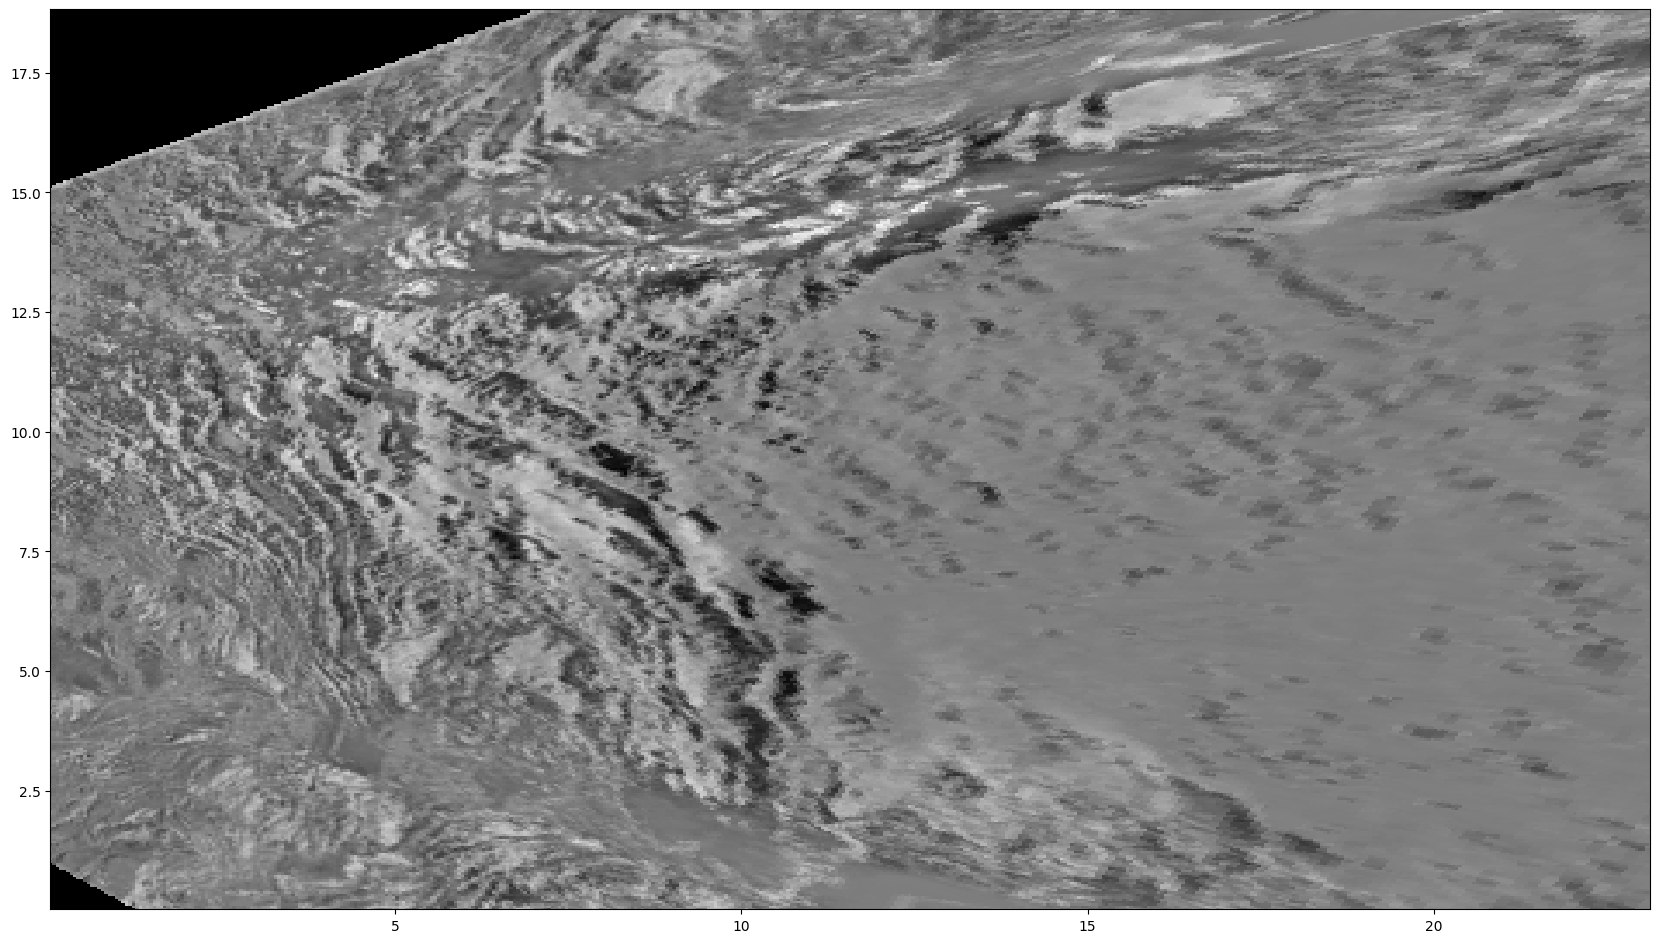

In [15]:
f = plt.figure(figsize=(16, 9))
da_norm_proj = da_norm.frames.project(method="numpy")
da_norm_proj[0].frames.plot(cmap="gray")

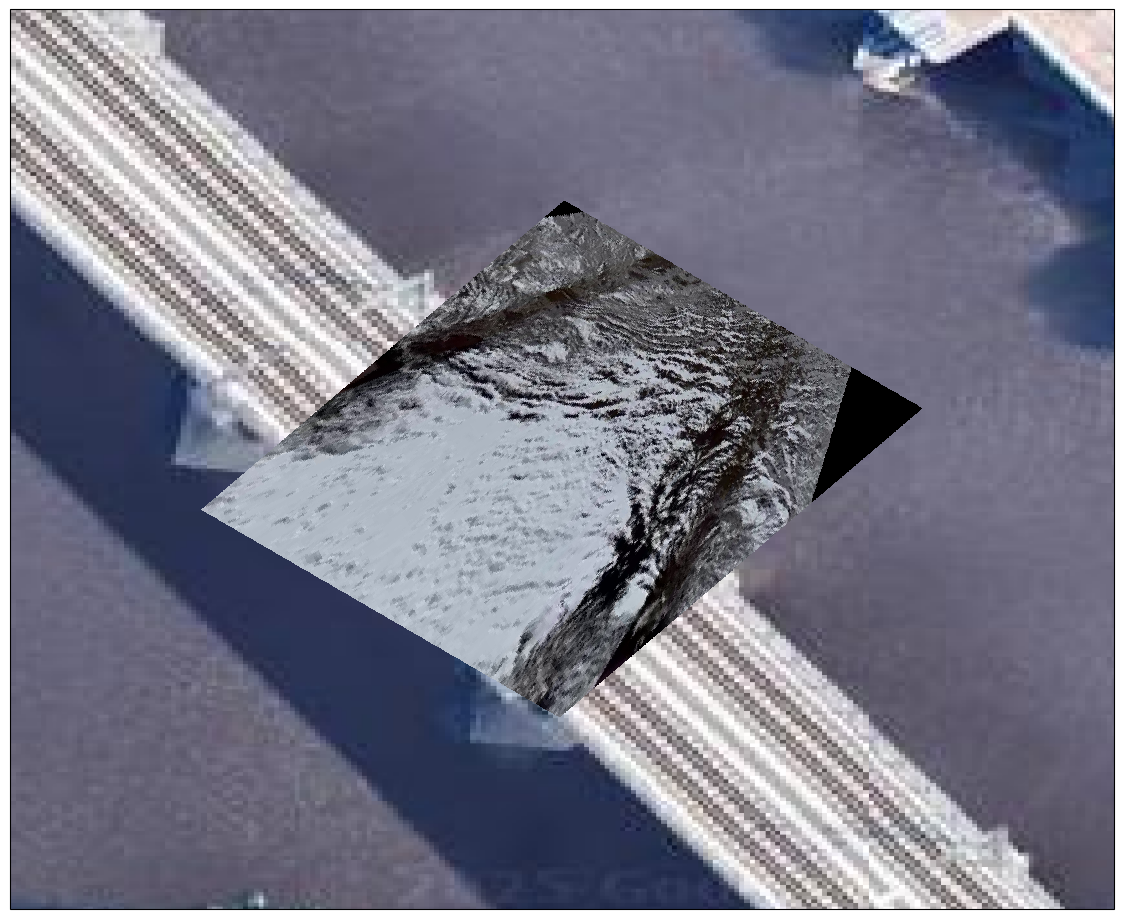

In [16]:
da_rgb = video.get_frames(method="rgb")
# project the rgb frames, same as before
da_rgb_proj = da_rgb.frames.project()
# plot the first frame in geographical mode
p = da_rgb_proj[0].frames.plot(mode="geographical")

# for fun, let's also add a satellite background from cartopy
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
tiles = cimgt.GoogleTiles(style="satellite")
p.axes.add_image(tiles, 19)
# zoom out a little bit so that we can actually see a bit
p.axes.set_extent([
    da_rgb_proj.lon.min() - 0.0001,
    da_rgb_proj.lon.max() + 0.0001,
    da_rgb_proj.lat.min() - 0.0001,
    da_rgb_proj.lat.max() + 0.0001],
    crs=ccrs.PlateCarree()
)

In [17]:
piv = da_norm_proj.frames.get_piv(engine="numba")
piv.to_netcdf("./artifact/mask.nc")

  0%|          | 0/1 [00:00<?, ?it/s]

Computing PIV per chunk: 100%|██████████| 1/1 [00:04<00:00,  4.79s/it]


PermissionError: [Errno 13] Permission denied: 'c:\\Users\\willi\\Documents\\UniWill\\pmc\\testriviere\\BenchRiverCam\\FrameWork\\pyopenrivercam\\artifact\\mask.nc'